In [1]:
from obspy import read, read_inventory, Stream, Trace, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import correlate
from obspy.geodetics.base import gps2dist_azimuth
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy import signal
from scipy.signal import hilbert
from scipy.stats import circmean,circstd
from scipy.interpolate import interp1d

### Defining a few functions

Read in data, remove instrument response, detrend, apply 5% cosine taper and filter between 0.1-0.2Hz (5-10s) as this is the passband of Rayleigh-waves within the secondary microseism of interest.

The second function is to delete the first sample to help evenly split streams read in.

In [2]:
def get_and_remove_response(station, channel, location, output, t1, t2):
    client = Client("http://service.geonet.org.nz")
    st = client.get_waveforms(
        network="NZ", station=station, location=location,
        channel=channel, starttime=t1, endtime=t2)
    tr = Stream()
    st.merge(fill_value='interpolate')
    print(st)
    for n in range(len(st)):
        
        inv = client.get_stations(
            network=st[n].stats.network, station=st[n].stats.station, 
            location=st[n].stats.location, channel=st[n].stats.channel, 
            level="response", startbefore=t1, endafter=t2)
        # filter for the secondary microseism
        pre_filt = (0.05, 0.1, 0.2, 0.4)
        st[n].detrend('linear')
        st[n].taper(max_percentage=0.05, type='cosine')
        st[n].filter('bandpass', freqmin=0.1, freqmax=0.2, zerophase=True)
        st[n].remove_response(output=output, pre_filt=False, plot=False,
                       water_level=60, inventory=inv)
        tr += st[n]

    return tr

In [3]:
def equal_and_split(st, id, stacks):
	st = st.select(id=id)
	st = np.delete(st, 0, 1)
	rec_st = np.hsplit(st[0].data, stacks)

	return rec_st

### Initial Parameters

Setting our receiver and source stations. Here URZ is a borehole site with unknown horizontal component orientations (HH1/HH2) which we would like to estimate. KNZ acts as our source station to correlate and produce the Green's tensor pairs, KNZ is near URZ in the Hawkes Bay/East Cape region of NZ.

In [4]:
network = "NZ"
start = UTCDateTime("2021-06-10")
end = UTCDateTime("2021-06-12")
rec_station = 'URZ'
rec_lat = -38.2592
rec_long = 177.1109
src_station = 'KNZ'
src_lat = -39.0218
src_long = 177.6737
channel = "HH*"
data_provider = "GEONET"

In [5]:
# create a list of days
datelist = pd.date_range(start.datetime, end.datetime, freq="D")
print(datelist)
c = Client(data_provider)
# format if mseed is saved
nslc = "{}.{}.{}.{}".format(network, rec_station, src_station, channel)
# make sure that wildcard characters are not in nslc
nslc = nslc.replace("*", "").replace("?", "")

DatetimeIndex(['2021-06-10', '2021-06-11', '2021-06-12'], dtype='datetime64[ns]', freq='D')


In [6]:
for day in datelist:
    datestr = day.strftime("%Y-%m-%d")
    fn = "{}_{}".format(datestr, nslc)
    print(fn)
    try:
        loc = '10'
        t1 = UTCDateTime(day)
        t2 = UTCDateTime(day) + 86400
        rec_st = get_and_remove_response(station=rec_station, channel=channel, location=loc, output='VEL', t1=t1, t2=t2)
        src_st = get_and_remove_response(station=src_station, channel=channel, location=loc, output='VEL', t1=t1, t2=t2)
        rec_st.sort()
        src_st.sort()
        # split the daily component streams into 1800s windows within an array 
        rec_hhz = equal_and_split(st=rec_st, id="NZ."+rec_station+"."+loc+".HHZ", stacks=86400/1800)
        rec_hh1 = equal_and_split(st=rec_st, id="NZ."+rec_station+"."+loc+".HH1", stacks=86400/1800)
        rec_hh2 = equal_and_split(st=rec_st, id="NZ."+rec_station+"."+loc+".HH2", stacks=86400/1800)
        src_hhz = equal_and_split(st=src_st, id="NZ."+src_station+"."+loc+".HHZ", stacks=86400/1800)
        src_hhn = equal_and_split(st=src_st, id="NZ."+src_station+"."+loc+".HHN", stacks=86400/1800)
        src_hhe = equal_and_split(st=src_st, id="NZ."+src_station+"."+loc+".HHE", stacks=86400/1800)
        
        zz_ccfs = []
        rz_ccfs = []
        tz_ccfs = []
        
        for i in range(len(rec_hhz)):
            zz_corr = correlate(rec_hhz[i],src_hhz[i],120*100)
            rz_corr = correlate(rec_hh1[i],src_hhz[i],120*100)
            tz_corr = correlate(rec_hh2[i],src_hhz[i],120*100)
            zz_ccfs.append(zz_corr)
            rz_ccfs.append(rz_corr)
            tz_ccfs.append(tz_corr)
            
        zz = np.array(zz_ccfs, dtype=np.float32)
        rz = np.array(rz_ccfs, dtype=np.float32)
        tz = np.array(tz_ccfs, dtype=np.float32)
        zz_stacked = zz.sum(axis=0) / len(zz)
        rz_stacked = rz.sum(axis=0) / len(rz)
        tz_stacked = tz.sum(axis=0) / len(tz)
        
        np.save(fn + '_ZZ.npy', zz_stacked)
        np.save(fn + '_RZ.npy', rz_stacked)
        np.save(fn + '_TZ.npy', tz_stacked)
            
        
    except Exception as e:
        print(e)

2021-06-10_NZ.URZ.KNZ.HH
3 Trace(s) in Stream:
NZ.URZ.10.HH1 | 2021-06-10T00:00:00.000000Z - 2021-06-11T00:00:00.000000Z | 100.0 Hz, 8640001 samples
NZ.URZ.10.HH2 | 2021-06-10T00:00:00.000000Z - 2021-06-11T00:00:00.000000Z | 100.0 Hz, 8640001 samples
NZ.URZ.10.HHZ | 2021-06-10T00:00:00.000000Z - 2021-06-11T00:00:00.000000Z | 100.0 Hz, 8640001 samples


/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


3 Trace(s) in Stream:
NZ.KNZ.10.HHE | 2021-06-10T00:00:00.003130Z - 2021-06-11T00:00:00.003130Z | 100.0 Hz, 8640001 samples
NZ.KNZ.10.HHN | 2021-06-10T00:00:00.003130Z - 2021-06-11T00:00:00.003130Z | 100.0 Hz, 8640001 samples
NZ.KNZ.10.HHZ | 2021-06-10T00:00:00.003130Z - 2021-06-11T00:00:00.003130Z | 100.0 Hz, 8640001 samples


/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


2021-06-11_NZ.URZ.KNZ.HH
3 Trace(s) in Stream:
NZ.URZ.10.HH1 | 2021-06-11T00:00:00.000000Z - 2021-06-12T00:00:00.000000Z | 100.0 Hz, 8640001 samples
NZ.URZ.10.HH2 | 2021-06-11T00:00:00.000000Z - 2021-06-12T00:00:00.000000Z | 100.0 Hz, 8640001 samples
NZ.URZ.10.HHZ | 2021-06-11T00:00:00.000000Z - 2021-06-12T00:00:00.000000Z | 100.0 Hz, 8640001 samples


/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


3 Trace(s) in Stream:
NZ.KNZ.10.HHE | 2021-06-11T00:00:00.003128Z - 2021-06-12T00:00:00.003128Z | 100.0 Hz, 8640001 samples
NZ.KNZ.10.HHN | 2021-06-11T00:00:00.003128Z - 2021-06-12T00:00:00.003128Z | 100.0 Hz, 8640001 samples
NZ.KNZ.10.HHZ | 2021-06-11T00:00:00.003128Z - 2021-06-12T00:00:00.003128Z | 100.0 Hz, 8640001 samples


/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


2021-06-12_NZ.URZ.KNZ.HH
3 Trace(s) in Stream:
NZ.URZ.10.HH1 | 2021-06-12T00:00:00.000000Z - 2021-06-13T00:00:00.000000Z | 100.0 Hz, 8640001 samples
NZ.URZ.10.HH2 | 2021-06-12T00:00:00.000000Z - 2021-06-13T00:00:00.000000Z | 100.0 Hz, 8640001 samples
NZ.URZ.10.HHZ | 2021-06-12T00:00:00.000000Z - 2021-06-13T00:00:00.000000Z | 100.0 Hz, 8640001 samples


/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


3 Trace(s) in Stream:
NZ.KNZ.10.HHE | 2021-06-12T00:00:00.003130Z - 2021-06-13T00:00:00.003130Z | 100.0 Hz, 8640001 samples
NZ.KNZ.10.HHN | 2021-06-12T00:00:00.003130Z - 2021-06-13T00:00:00.003130Z | 100.0 Hz, 8640001 samples
NZ.KNZ.10.HHZ | 2021-06-12T00:00:00.003130Z - 2021-06-13T00:00:00.003130Z | 100.0 Hz, 8640001 samples


/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/conradb/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


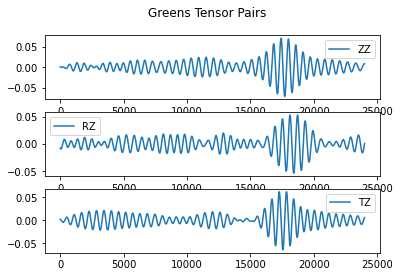

In [7]:
ZZ_all = []
RZ_all = []
TZ_all = []

for day in datelist:
    datestr = day.strftime("%Y-%m-%d")
    daily_zz = np.load(str(datestr)+'_NZ.URZ.KNZ.HH_ZZ.npy')
    ZZ_all.append(daily_zz)
    daily_rz = np.load(str(datestr)+'_NZ.URZ.KNZ.HH_RZ.npy')
    RZ_all.append(daily_rz)
    daily_tz = np.load(str(datestr)+'_NZ.URZ.KNZ.HH_TZ.npy')
    TZ_all.append(daily_tz)
#print(s)
ZZ_sum = np.array(ZZ_all, dtype=np.float32).sum(axis=0) / len(datelist)
RZ_sum = np.array(RZ_all, dtype=np.float32).sum(axis=0) / len(datelist)
TZ_sum = np.array(TZ_all, dtype=np.float32).sum(axis=0) / len(datelist)

fig, axs = plt.subplots(3)
fig.suptitle('Greens Tensor Pairs')
axs[0].plot(ZZ_sum, label='ZZ')
axs[0].legend()
axs[1].plot(RZ_sum, label='RZ')
axs[1].legend()
axs[2].plot(TZ_sum, label='TZ')
axs[2].legend()
plt.show()

In [8]:
# Fill header attributes
stats = {'network': 'NZ', 'station': rec_station, 'location': '10',
         'channel': 'HHZ', 'npts': len(ZZ_sum), 'sampling_rate': 100,
         'mseed': {'dataquality': 'D'}}
stats2 = {'network': 'NZ', 'station': rec_station, 'location': '10',
         'channel': 'HH1', 'npts': len(RZ_sum), 'sampling_rate': 100,
         'mseed': {'dataquality': 'D'}}
stats3 = {'network': 'NZ', 'station': rec_station, 'location': '10',
         'channel': 'HH2', 'npts': len(TZ_sum), 'sampling_rate': 100,
         'mseed': {'dataquality': 'D'}}

# set current time to the first day
stats['starttime'] = start
stats2['starttime'] = start
stats3['starttime'] = start
    
st = Stream([Trace(data=ZZ_sum, header=stats)])
st2 = Stream([Trace(data=RZ_sum, header=stats2)])
st3 = Stream([Trace(data=TZ_sum, header=stats3)])

# write as ASCII file (encoding=0)
st.write(rec_station+"_"+src_station+"_ZZ.mseed", format='MSEED', encoding="FLOAT32", reclen=512)
st2.write(rec_station+"_"+src_station+"_RZ.mseed", format='MSEED', encoding="FLOAT32", reclen=512)
st3.write(rec_station+"_"+src_station+"_TZ.mseed", format='MSEED', encoding="FLOAT32", reclen=512)



### Folding the CCF's (Greens Tensor Pairs)

Now we have our cross correlation functions which are a representation of the greens tensor between sites. As we are only interested in the impulse travelling from KNZ to URZ we can fold the CCF to improve the SNR as the impulses should be symmetrical about the 120s shift (12000 samples shift). Let's define the function to fold and taper.

In [9]:
def fold_ccfs(zz,rz,tz):
	st = read(zz)
	st += read(rz)
	st += read(tz)

	# From one trace, pick off some constants we'll need:
	starttime = st[0].stats.starttime
	delta  = st[0].stats.delta
	npts2 = st[0].stats.npts
	npts = int((npts2-1)/2)

	#Improve ccf SNR by folding
	st_folded= st.copy()
	for i_,tr in enumerate(st):
		causal =  st[i_].data[npts:-1]
		acausal = st[i_].data[npts:0:-1]
		st_folded[i_].data[0:npts] =  (causal+acausal)/2


	#Keep only the first half of the stream, as that is where all the action is.
	st_folded.trim(starttime=starttime, endtime=starttime+npts*delta)
	st_folded.taper(max_percentage=0.05, type='cosine')

	# Order ccf streams
	st_folded.sort() 
	ZZ = st_folded.select(id='NZ.'+rec_station+'.10.HHZ')
	RZ = st_folded.select(id='NZ.'+rec_station+'.10.HH1')
	TZ = st_folded.select(id='NZ.'+rec_station+'.10.HH2')

	return ZZ,RZ,TZ

In [10]:
ZZ,RZ,TZ = fold_ccfs(zz='URZ_KNZ_ZZ.mseed', rz='URZ_KNZ_RZ.mseed',tz='URZ_KNZ_TZ.mseed')

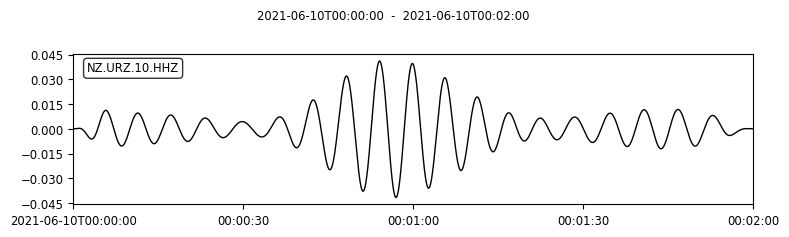

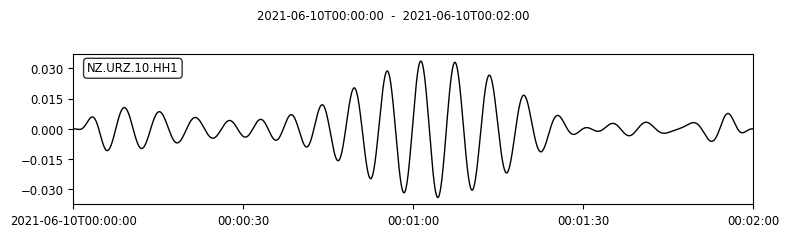

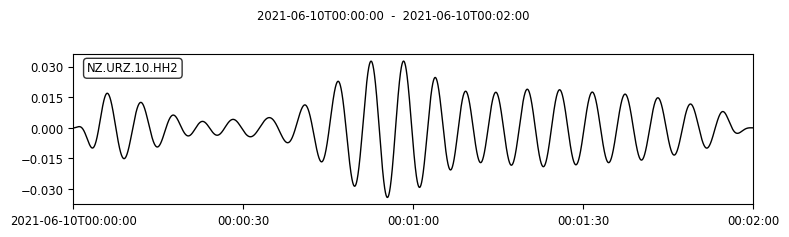

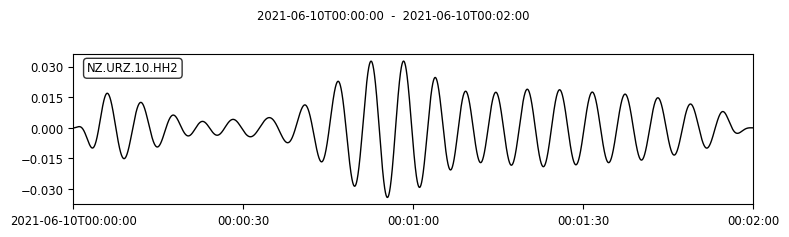

In [11]:
ZZ.plot()
RZ.plot()
TZ.plot()

In [12]:
ZZ_hil = np.imag(hilbert(ZZ[0].data))
Szz = np.correlate(ZZ_hil,ZZ_hil)

# rotating anti-clockwise and correlating with ZZ_hil

maxSrz= []

# build values from 0 to 2pi in 1/360 increments
thetas = np.linspace(0,2*np.pi,360)
for i_,theta in enumerate(thetas):
	RZ_rot =  np.cos(theta)*RZ[0].data - np.sin(theta)*TZ[0].data
	TZ_rot = np.sin(theta)*RZ[0].data + np.cos(theta)*TZ[0].data
	Srz = np.correlate(RZ_rot, ZZ_hil)
	Szz = np.correlate(ZZ_hil, ZZ_hil)
	maxSrz.append(max(Srz)/max(Szz))

In [13]:
# find the angle with the maximum correlation:
maxmaxSrz= max(maxSrz)
# index of list with maximum correlation
rotangle_index = maxSrz.index(maxmaxSrz)
# value in radians
rotangle = thetas[rotangle_index]
# value in degrees
degrees = int(rotangle*180/np.pi)
# correlation coefficient value
corr_coeff = maxmaxSrz
print(degrees)
print(corr_coeff)

43
0.906354799028


In [14]:
back_azi = gps2dist_azimuth(rec_lat, rec_long, src_lat, src_long)
print(back_azi)
source_azi = back_azi[1]
print(source_azi)

#anti-clockwise-hh1-rot
correction = ((source_azi + degrees) + 360) % 360
print(correction)

(97812.57348266397, 150.11274643543766, 329.76130664729453)
150.11274643543766
193.11274643543766


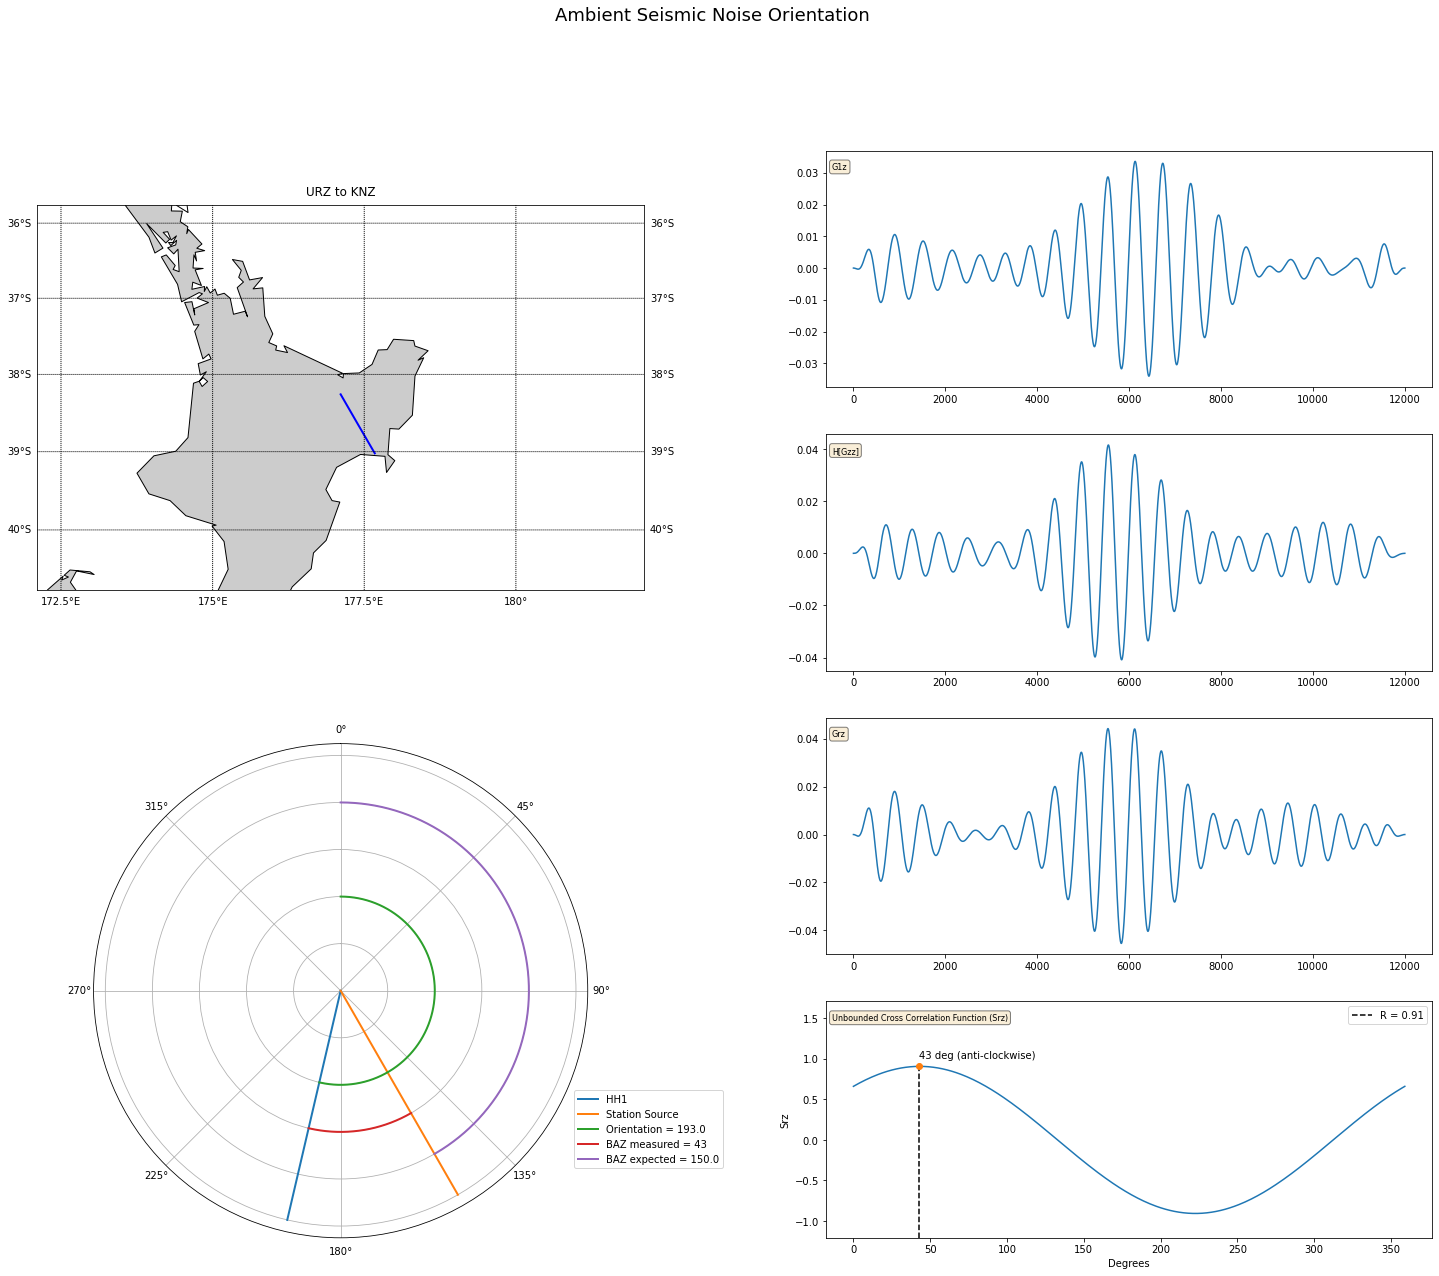

In [15]:
# plotting

fig = plt.figure(figsize=(25,20))
fig.suptitle('Ambient Seismic Noise Orientation', fontsize=18)


# Plot the basemap of event and station

plt.subplots_adjust(wspace= 0.3, hspace= 0.2)

ax1 = fig.add_subplot(2, 2, 1)

m = Basemap(llcrnrlon=rec_long-5,llcrnrlat=rec_lat-2.5,urcrnrlon=rec_long+5.,urcrnrlat=rec_lat+2.5,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=rec_lat,lon_0=rec_long,lat_ts=None)

# draw great circle route between refrence and source sites
m.drawgreatcircle(rec_long,rec_lat,src_long,src_lat,linewidth=2,color='b')
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(-90,0,1),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,2.5),labels=[1,1,0,1])
ax1.set_title(rec_station+' to '+src_station, pad=10)




# Plot the polar plot showing event back azi and sensor orientation

ax2 = fig.add_subplot(2, 2, 3, projection='polar')

r = [1, 1,]
theta = [np.radians(correction), np.radians(source_azi)]
labels = ['HH1','Station Source']


for i in range(len(r)):
    ax2.plot([0, theta[i]], [0, r[i]], linewidth=2, label=labels[i])
    


ax2.set_yticklabels([])
ax2.set_theta_zero_location('N')

# Go clockwise
ax2.set_theta_direction(-1)
# # Start from the top
# ax2.set_theta_offset(np.pi/2)

# Connect two points with a curve

for curve in [[[0, correction], [0.4, 0.4]]]:
    curve[0] = np.deg2rad(curve[0])
    x = np.linspace( curve[0][0], curve[0][1], 500)
    y = interp1d( curve[0], curve[1])( x)
    ax2.plot(x, y, linewidth=2, label='Orientation'+ ' = ' + str(np.around(correction,0)))

for curve in [[[source_azi,correction], [0.6, 0.6]]]:
	# ax2.set_theta_direction(1)
	curve[0] = np.deg2rad(curve[0])
	x = np.linspace( curve[0][0], curve[0][1], 500)
	y = interp1d( curve[0], curve[1])( x)
	ax2.plot(x, y, linewidth=2, label='BAZ measured'+ ' = ' + str(np.round(degrees,0)))

for curve in [[[0, source_azi], [0.8, 0.8]]]:
    curve[0] = np.deg2rad(curve[0])
    x = np.linspace( curve[0][0], curve[0][1], 500)
    y = interp1d( curve[0], curve[1])( x)
    ax2.plot(x, y, linewidth=2, label='BAZ expected'+ ' = ' + str(np.round(source_azi,0)))

angle = np.deg2rad(337.5)
ax2.legend(loc='upper left', bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))


# Plot the 1Z impluse, RZ impulse, Hilbert transformed ZZ impulse and CCF


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax3 = fig.add_subplot(4,2,2)
ax3.plot(RZ[0].data)
ax3.text(0.01, 0.95, 'G1z', transform=ax3.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax4 = fig.add_subplot(4,2,4)
ax4.plot(ZZ_hil)
ax4.text(0.01, 0.95,'H[Gzz]', transform=ax4.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax5 = fig.add_subplot(4,2,6)
ax5.plot(np.cos(rotangle)*RZ[0].data - np.sin(rotangle)*TZ[0].data)
ax5.text(0.01, 0.95,'Grz', transform=ax5.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)


ax6 = fig.add_subplot(4,2,8)
ax6.plot(maxSrz)
ax6.plot(degrees, corr_coeff, "o")
ax6.vlines(degrees, min(maxSrz)-0.5, corr_coeff, linestyles='dashed', color='k', label='R = '+str(np.round(corr_coeff,2)))
ax6.set_ylim(min(maxSrz)-0.3,max(maxSrz)+0.8)
ax6.text(0.01, 0.95, 'Unbounded Cross Correlation Function (Srz)', transform=ax6.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax6.text(degrees, corr_coeff + 0.1, str(degrees) + ' deg (anti-clockwise)')
ax6.legend(loc='best')
ax6.set_xlabel('Degrees')
ax6.set_ylabel('Srz')




# fig.tight_layout()
plt.show()